In [70]:
#| default_exp tfsm/erase

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| export 
import numpy as np 
import fastcore.all as fc
from voxdet.bbox_func.bbox_iou import calculate_iou
from voxdet.tfsm.standard import BaseT

In [4]:
from voxdet.utils import vis

In [5]:
def fill_bbox(image, bbox):
    image = np.copy(image)
    for box in bbox:
        z1, y1, x1, z2, y2, x2 = box.astype(np.int32)
        image[..., z1:z2, y1:y2, x1:x2] = 1 
    return image

In [6]:
image = np.zeros((32, 192, 192))
bbox = np.asarray([[10., 150., 100, 20., 190., 190.], [10., 10., 10, 50., 50., 50.]])
imgb = fill_bbox(image, bbox)

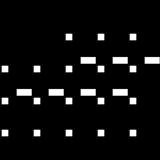

In [7]:
vis(imgb*255, 32, window=False)

In [8]:
ims = imgb.shape
ps = (4, 8, 8)

In [9]:
ps

(4, 8, 8)

In [10]:
patches_per_dim = ims//np.asarray(ps)
patches_per_dim

array([ 8, 24, 24])

In [11]:
indices = np.indices(patches_per_dim).reshape(3, -1).T
indices

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [ 7, 23, 21],
       [ 7, 23, 22],
       [ 7, 23, 23]])

In [12]:
patches = np.concatenate((indices*ps, (indices+1)*ps), axis=1)
patches

array([[  0,   0,   0,   4,   8,   8],
       [  0,   0,   8,   4,   8,  16],
       [  0,   0,  16,   4,   8,  24],
       ...,
       [ 28, 184, 168,  32, 192, 176],
       [ 28, 184, 176,  32, 192, 184],
       [ 28, 184, 184,  32, 192, 192]])

In [13]:
#| export 
def get_patches(ims, patch_size):
    #ims is img_size, patch_size is tuple with same dimension as ims
    patches_per_dim = ims//np.asarray(patch_size)
    indices = np.indices(patches_per_dim).reshape(3, -1).T
    patches = np.concatenate((indices*patch_size, (indices+1)*patch_size), axis=1)
    return patches

In [14]:
%time 
tpatches = get_patches((96, 196, 196), (4, 8, 8))
tpatches.shape

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 12.4 µs


(13824, 6)

In [15]:
def draw_boxes_on_image(image, boxes):
    drawn_image = np.copy(image)
    for box in boxes:
        zmin, ymin, xmin = np.floor(box[:3]).astype(int)
        zmax, ymax, xmax = np.ceil(box[3:]).astype(int)-1

        drawn_image[zmin, ymin:ymax, xmin:xmax] = 1
        drawn_image[zmax, ymin:ymax, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymin, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymax, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymin:ymax, xmin] = 1
        drawn_image[zmin:zmax, ymin:ymax, xmax] = 1
    return drawn_image

In [16]:
pimg = draw_boxes_on_image(imgb, patches)
pimg.shape

(32, 192, 192)

In [17]:
ious = calculate_iou(patches, bbox)
ious.nonzero()[0].shape

(432,)

In [18]:
req_patches = patches[np.where(~ious.any(axis=1))[0]]
req_patches

array([[  0,   0,   0,   4,   8,   8],
       [  0,   0,   8,   4,   8,  16],
       [  0,   0,  16,   4,   8,  24],
       ...,
       [ 28, 184, 168,  32, 192, 176],
       [ 28, 184, 176,  32, 192, 184],
       [ 28, 184, 184,  32, 192, 192]])

In [19]:
mask_perc = 0.2
tokens = req_patches.shape[0]
mask_tokens = np.random.randint(tokens, size=int(mask_perc*tokens))
mask_tokens.shape

(835,)

In [20]:
fpatches = req_patches[mask_tokens]
fpatches.shape

(835, 6)

In [21]:
assert calculate_iou(fpatches, bbox).nonzero()[0].shape[0] == 0

In [22]:
#| export 
def masked_patches_dim(patches, bbox=None, mask_perc=0.2, use_bbox=False):
    if use_bbox: 
        if bbox is None: raise ValueError("bbox cannot be None when u want to use bbox")
        ious = calculate_iou(patches, bbox)
        patches = patches[np.where(~ious.any(axis=1))[0]]
    masked_patches = np.random.randint(patches.shape[0], size=int(mask_perc*patches.shape[0]))
    return patches[masked_patches]

In [23]:
masked_patches_dim(patches, bbox, use_bbox=True).shape

(835, 6)

In [24]:
for patch in fpatches:
    z1, y1, x1, z2, y2, x2 = patch
    imgb[z1:z2, y1:y2, x1:x2] = np.random.beta(5, 2, size=ps)

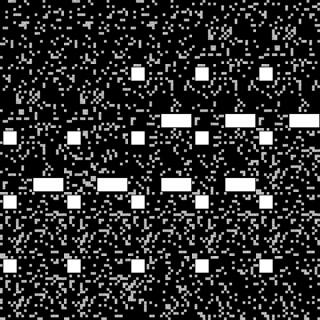

In [25]:
vis(imgb*255, 64, window=False)

In [26]:
# the test is to check that everything inside bbox remained same or not.
def test_mask(imgb, bbox):
    bbox = bbox.astype(np.int32)
    for box in bbox: assert (imgb[box[0]:box[3], box[1]:box[4], box[2]:box[5]] == 1).all()

In [27]:
test_mask(imgb, bbox)

## floating point bounding boxes. 
in case if the bounding boxes are floating points, we need to take bboxes with largest dimension.

In [28]:
bbox = np.asarray([[3.1, 2.9, 4.2, 5.6, 2.2, 3.9], [4.1, 1.2, 3.2, 5.8, 5.9, 5.2]])
bbox

array([[3.1, 2.9, 4.2, 5.6, 2.2, 3.9],
       [4.1, 1.2, 3.2, 5.8, 5.9, 5.2]])

In [29]:
np.floor(bbox[:, :3])

array([[3., 2., 4.],
       [4., 1., 3.]])

In [30]:
np.ceil(bbox[:, 3:])

array([[6., 3., 4.],
       [6., 6., 6.]])

In [31]:
bbox[:, :3] = np.floor(bbox[:, :3])
bbox[:, 3:] = np.ceil(bbox[:, 3:])
bbox = bbox.astype(np.int32)
bbox

array([[3, 2, 4, 6, 3, 4],
       [4, 1, 3, 6, 6, 6]], dtype=int32)

In [32]:
#| export 
def _bbox3d_f2in(bbox):
    # convert a 3d bounding from float to int
    bbox[:, :3] = np.floor(bbox[:, :3])
    bbox[:, 3:] = np.ceil(bbox[:, 3:])
    bbox = bbox.astype(np.int32)
    return bbox

## Merge everything 

In [35]:
#| export 
def random_erase_3d(imgb, ps, bbox=None, mask_perc=0.2, mask_type="beta"):
    # imgb is zyx/nzyx ps is zyx bbox is zyxzyx mask_type can be "beta", "zeros", "ones"
    if mask_type not in ["beta", "zeros", "ones"]: raise ValueError(f"mask type {mask_type} not one of beta, zeros ones")
    ims = imgb.shape if len(imgb.shape) == 3 else imgb.shape[1:]
    bbox = _bbox3d_f2in(bbox.copy())
    if len(ims) != len(ps): raise ValueError(f"image shape and ps size should be same. got ims={ims}, ps={ps}")
    patches = get_patches(ims, ps)
    patches = masked_patches_dim(patches, bbox, mask_perc, use_bbox=True if bbox is not None else False)
    mask_val = 0 if mask_type == "zeros" else 1 
    for patch in patches:
        z1, y1, x1, z2, y2, x2 = patch
        imgb[..., z1:z2, y1:y2, x1:x2] = np.random.beta(5, 2, size=ps) if mask_type=="beta" else mask_val
    return imgb

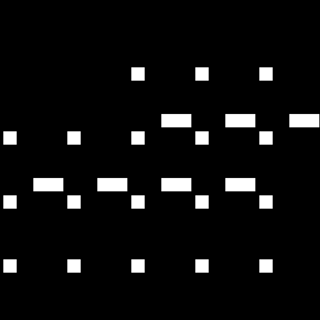

In [36]:
image = np.zeros((32, 192, 192))
bbox = np.asarray([[10., 150.2, 100, 20., 190., 190.], [10., 10.3, 10, 50., 50., 50.]])
imgb = fill_bbox(image, _bbox3d_f2in(bbox))
vis(imgb*255, 64, window=False)

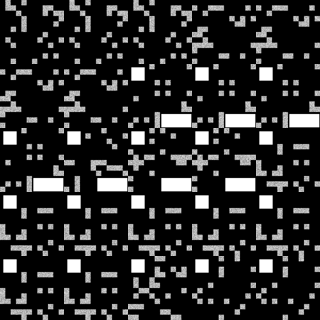

In [37]:
fimg = random_erase_3d(imgb, (4, 16, 16), bbox=bbox, mask_perc=0.2, mask_type="beta")
vis(fimg*255, 64, window=False)

In [38]:
test_mask(fimg, _bbox3d_f2in(bbox))

## 4D images test.

In [39]:
image = np.zeros((2, 32, 192, 192))
bbox = np.asarray([[10., 150.2, 100, 20., 190., 190.], [10., 10.3, 10, 50., 50., 50.]])
imgb = fill_bbox(image, _bbox3d_f2in(bbox))
fimg = random_erase_3d(imgb, (4, 16, 16), bbox=bbox, mask_perc=0.2, mask_type="beta")
test_mask(fimg, _bbox3d_f2in(bbox))

## RandomErase Transform

In [63]:
#| export 
class RandomErase(BaseT):
    def __init__(self, patch_size=(8, 16, 16), use_bbox:bool=False, mask_perc=0.2, mask_filler: str="beta", p:float=0.2):
        """crop_size is [zyx]"""
        super().__init__()
        fc.store_attr()
    __repr__ = fc.basic_repr(flds="patch_size, use_bbox, mask_perc, mask_filler, p")
    
    def apply(self, img: dict):
        assert "images" in img.keys()
        fimg = img["images"].copy()
        boxes = img["boxes"].copy()
        
        if isinstance(fimg , np.ndarray) :
            fimg = [fimg]
            boxes = [boxes]
                        
        for i in range(len(fimg)) :
            if np.random.random() <= self.p:
                b = boxes[i] if self.use_bbox else None
                fimg[i] = random_erase_3d(fimg[i], self.patch_size, bbox=b, \
                                                mask_perc=self.mask_perc, mask_type=self.mask_filler)
        
        if len(fimg) == 1 :
            img["images"] = fimg[0]
        else :
            img["images"] = fimg
                    
        return img

In [64]:
img = {}
img["images"] = imgb = fill_bbox(np.zeros((2, 32, 192, 192)), _bbox3d_f2in(bbox))
img["boxes"] = np.asarray([[10.2, 150.2, 100, 20., 190.2, 190.8], [10.6, 10.3, 10, 50.4, 50.5, 50.5]])
tfsm = RandomErase(use_bbox=True, p=1.0)

In [66]:
%timeit fimg = tfsm(img)

21.8 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


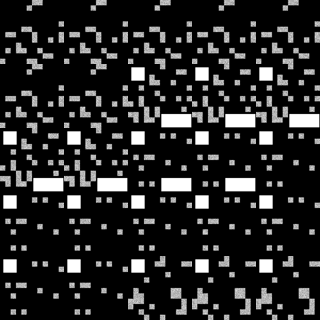

In [68]:
vis(fimg["images"][0]*255, 64, window=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()